In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import gc
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/bert-uncased/bert-base-uncased-vocab.txt
/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv


In [2]:
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
train0 =  pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
sub_sample = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
train = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv", sep=',')

In [3]:
train0.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
train

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


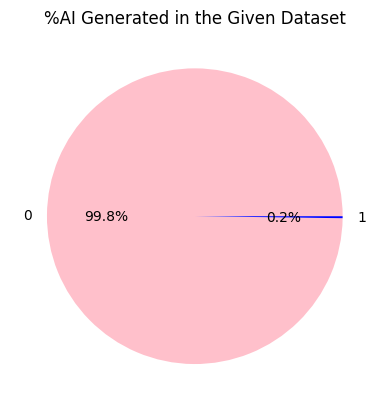

In [5]:
counts = train0['generated'].value_counts()
plt.pie(counts,labels=counts.index,autopct='%1.1f%%',colors=['pink','blue'])
plt.title("%AI Generated in the Given Dataset")
plt.show()

Hence from this we observe that the given dataset may not be appropriate for training the models

<Axes: title={'center': '%AI Generated in the External Dataset'}, xlabel='label'>

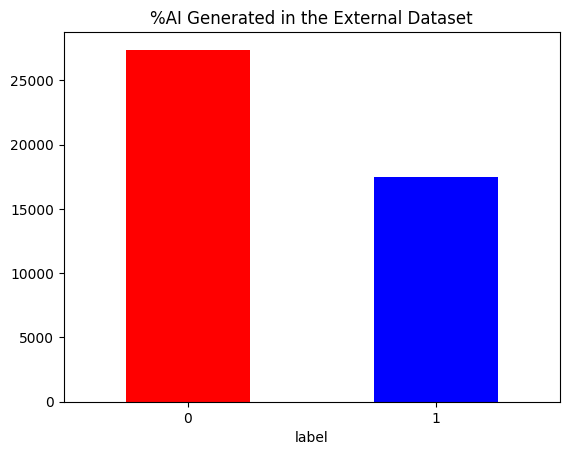

In [6]:
df = train
num_types = df.groupby(by='label').size()
plt.title("%AI Generated in the External Dataset")
num_types.plot.bar(color=['red','blue'],rot=0)

In [7]:
LOWERCASE = False #case-sensitive-ting

In [8]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

In [9]:
from datasets import Dataset
from tqdm.auto import tqdm
from tokenizers import Tokenizer
from tokenizers.models import BPE
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))# Byte Pair Encoding...
from tokenizers.trainers import BpeTrainer
trainer = BpeTrainer(vocab_size=30000,special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"], min_frequency=0)

In [10]:
from tokenizers.pre_tokenizers import Whitespace
tokenizer.pre_tokenizer = Whitespace()
from transformers import PreTrainedTokenizerFast


In [11]:
tokenizer_obj = Tokenizer(models.BPE(unk_token="[UNK]"))
tokenizer_obj.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
tokenizer_obj.pre_tokenizer = pre_tokenizers.ByteLevel()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=30000, special_tokens=special_tokens)
#30k is default size of vocab..

dataset = Dataset.from_pandas(test[['text']])
def train_corp_iter(): 
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]
tokenizer_obj.train_from_iterator(train_corp_iter(), trainer=trainer)
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer_obj,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
token_test = []

for tt in tqdm(test['text'].tolist()):
    token_test.append(tokenizer.tokenize(tt))

token_train = []

for tt in tqdm(train['text'].tolist()):
    token_train.append(tokenizer.tokenize(tt))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/44868 [00:00<?, ?it/s]

We basically calculated freequencies of different pairs of chars in the vocabulary and grouped them together as tokens :0

Make TF-ID vectorisation


We are using Bag of N-Grams for vectorization

In [12]:
def bruh(text):
    return text
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (2,5),lowercase = LOWERCASE , sublinear_tf = True,preprocessor=bruh
                            ,analyzer='word',strip_accents='unicode', tokenizer = bruh,token_pattern = None)

In [13]:
train_lol = vectorizer.fit_transform(token_train)
test_lol = vectorizer.transform(token_test)
del vectorizer
gc.collect()

21

In [14]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from sklearn.naive_bayes import MultinomialNB #naive_bayes
# import xgboost as xgb
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
mnb = MultinomialNB(alpha=0.02)
sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 
y_train = train['label'].values

weights = [0.35,0.65]
vc = VotingClassifier(estimators=[('naive',mnb),('sgd', sgd_model),],weights = weights,voting='soft', n_jobs=-1)
# clf = SVC(kernel='rbf', C=1e9, gamma=1e-07, probability=True).fit(train_lol,y_train)
# svc1.fit(train_lol,y_train)
# mnb.fit(train_lol,y_train)
 
vc.fit(train_lol,y_train)
gc.collect()
pred3 = vc.predict_proba(test_lol)[:,1]
# pred = mnb.predict_proba(test_lol)[:,1]
# pred2 = model.predict_proba(test_lol)[:,1]
sub_sample['generated'] = pred3
sub_sample.to_csv('submission.csv', index=False)

In [15]:
sub_sample

,id,generated
0,0000aaaa,0.454111
1,1111bbbb,0.454111
2,2222cccc,0.454111
